In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import nice_layers as vnn
import torchvision
from imp import reload

In [40]:
#MNIST 

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                            torchvision.transforms.Lambda(lambda x: torch.flatten(x))])
train_set = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, shuffle=False)


In [51]:
#CIFAR

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
nonneg = False
model = nn.Sequential(vnn.Linear(10, 784*10, 1200, nonneg=False, expanded_input=True),
                      vnn.tReLU(),
                      vnn.Linear(10, 1200, 600, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.Linear(10, 600, 1, nonneg=nonneg))

In [4]:
#update utilty
def set_model_grads(model, output, labels):
    targets = torch.eye(10, device=labels.device)[labels]
    output_error = F.softmax(output, dim=1) - targets
    for i in range(len(model)):
        layer = model[i]
        if type(layer) in (vnn.Conv2d, vnn.Linear):
            if (i == len(model) - 1) or (type(model[i+1]) not in (vnn.ReLU, vnn.tReLU)):
                mask = torch.ones(layer.mask_shape, device=output.device)
            else:
                mask = model[i+1].mask
            layer.set_grad(mask, output_error)
    nans = np.any([torch.any(torch.isnan(p)).item() for p in model.parameters()])
    if nans:
        print("Warning: NAN!")
            
            
def expand_input(input, category_dim):
    batch_dim, input_dim = input.shape
    expanded_input = torch.zeros(batch_dim, category_dim, category_dim*input_dim)
    for i in range(category_dim):
        expanded_input[:, i, i*input_dim:(i+1)*input_dim] = input
    return expanded_input

def expand_input_conv(input, category_dim):
    #input = (batch, channels, width, height)
    batch_size, in_channels = input.shape[:2]
    expanded_input = torch.zeros((batch_size, category_dim, in_channels*category_dim) + input.shape[2:])
    for i in range(category_dim):
        expanded_input[:, i, i*in_channels:(i+1)*in_channels] = input
    return expanded_input

In [37]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

for epoch_idx in range(1000):
    print(epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        input = expand_input(data, 10)
        with torch.no_grad():
            out = model(input)[..., 0]
        epoch_loss += loss_fn(out, labels).item()
        epoch_correct += (out.argmax(dim=1) == labels).float().sum()
        opt.zero_grad()
        set_model_grads(model, out, labels)
        opt.step()
        for layer in model: layer.post_step_callback()
    print(epoch_loss / (batch_idx + 1))
    print(epoch_correct / 60000.)

0
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)


KeyboardInterrupt: 

In [38]:
num_correct = 0
for batch_idx, (data, labels) in enumerate(test_loader):
    input = expand_input(data, 10)
    with torch.no_grad():
        out = model.forward(input)[..., 0]
    num_correct += (out.argmax(dim=1) == labels).int().sum().item()
acc = num_correct / 10000.
acc

0.9174

In [22]:
def init_conv_l0(weight, category_dim=1):
    out_channels, in_channels, kernel_size = weight.shape[:3] #assumes square kernel
    W_shape = weight.shape[1:]
    for i in range(out_channels // 2):
        W = torch.randn(W_shape) / np.sqrt((in_channels / category_dim) * kernel_size**2)
        weight[2*i] = W
        weight[2*i + 1] = -W

def init_conv(weight):
    out_channels, in_channels, kernel_size = weight.shape[:3] #assumes square kernel
    W_shape = weight.shape[2:]
    for i in range(out_channels // 2):
        for j in range(in_channels // 2):
            W = torch.randn(W_shape) / np.sqrt(0.25 * in_channels * kernel_size**2)
            i1, i2 = i*2, i*2 + 1
            j1, j2 = j*2, j*2 + 1
            weight[i1, j1] = F.relu(W)
            weight[i2, j2] = F.relu(W)
            weight[i1, j2] = F.relu(-W)
            weight[i2, j1] = F.relu(-W)
                
def init_t(t):
    features = t.shape[1]
    for i in range(features // 2):
        t[:, 2*i + 1] = -t[:, 2*i]
                
            

Instantiated t with shape (10, 96, 14, 14)
Instantiated t with shape (10, 96, 6, 6)
Instantiated t with shape (10, 96, 4, 4)


0.039878096

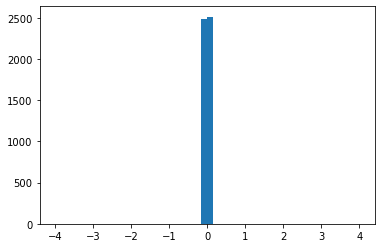

In [314]:
reload(vnn)
nonneg = False
model = nn.Sequential(vnn.Conv2d(10, 30, 96, 5, stride=2, nonneg=False, expanded_input=True),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96, 96, 3, stride=2, nonneg=nonneg, expanded_input=False),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96, 96, 3, stride=1, nonneg=nonneg, expanded_input=False),
                      vnn.tReLU(),
                      vnn.Flatten(),
                      vnn.Linear(10, 1536, 1, nonneg=nonneg)).to(0)

data = torch.randn(500, 3, 32, 32)
input = expand_input_conv(data, 10).to(0)
out = model(input)

"""
with torch.no_grad():
    init_conv_l0(model[0].conv.weight, category_dim=10)
    init_t(model[1].t)
    init_conv(model[2].conv.weight)
    init_t(model[3].t)
    init_conv(model[4].conv.weight)
    init_t(model[5].t)
    W_last = (1./0.8) * torch.randn(1536 // 2) / np.sqrt(0.25 * 1536)
    model[7].weight *= 0.
    model[7].weight[0, ::2] = F.relu(W_last)
    model[7].weight[0, 1::2] = F.relu(-W_last)
    

out = model(input)
vals = out.cpu().detach().numpy().flatten()

plt.hist(vals, bins=50, range=(-4, 4))
vals.std()
"""

vals = out.cpu().detach().numpy().flatten()
plt.hist(vals, bins=50, range=(-4, 4))
vals.std()

In [315]:
model[:7](input).shape

torch.Size([500, 10, 1536])

In [316]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
opt = optim.Adam(model.parameters(), lr=1e-3) #, momentum=0.0)

for epoch_idx in range(1000):
    print(epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        if batch_idx % 100 == 0:
            print(batch_idx)
        input = expand_input_conv(data, 10).to(0)
        with torch.no_grad():
            out = model(input)[..., 0]
        epoch_loss += loss_fn(out, labels.to(0)).item()
        c = (out.argmax(dim=1).cpu() == labels).float().sum().item()
        epoch_correct += c
        opt.zero_grad()
        set_model_grads(model, out, labels.to(0))
        opt.step()
        for layer in model: layer.post_step_callback()
    print(epoch_loss / (batch_idx + 1))
    print(epoch_correct / 50000.)

0
0
100
200
300
1.9368599012989522
0.29758
1
0
100


KeyboardInterrupt: 

In [302]:
#opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
#data = torch.randn(500, 3, 32, 32)
#labels = torch.randint(0, 10, (len(data),))

In [303]:
input = expand_input_conv(data, 10).to(0)
with torch.no_grad():
    out = model(input)[..., 0]
opt.zero_grad()
set_model_grads(model, out, labels.to(0))
G1 = model[0].conv.weight.grad.detach().cpu().numpy().flatten()

In [304]:
input = expand_input_conv(data, 10).to(0)
out = model(input)[..., 0]
loss = loss_fn(out, labels.to(0))
opt.zero_grad()
loss.backward()
G2 = model[0].conv.weight.grad.detach().cpu().numpy().flatten()

In [305]:
G1.shape, G2.shape

((72000,), (72000,))

In [306]:
from scipy.stats import pearsonr
pearsonr(G1.flatten(), G2.flatten())

(0.8984318343042683, 0.0)

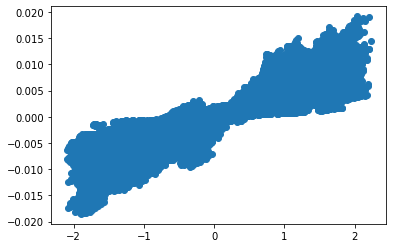

In [307]:
plt.scatter(G1, G2)

In [230]:
linregress(G1, G2)

LinregressResult(slope=0.08156824135508328, intercept=-5.607639407292361e-06, rvalue=0.4925036566970165, pvalue=0.0, stderr=0.0005004936230648975)

In [193]:
model[4].conv.weight.max()

tensor(1.5515, device='cuda:0', grad_fn=<MaxBackward1>)

In [238]:
torch.rand((10, 10))

tensor([[0.8324, 0.5145, 0.7072, 0.6131, 0.2930, 0.6666, 0.8563, 0.6071, 0.0702,
         0.4819],
        [0.8280, 0.7013, 0.8857, 0.9641, 0.6493, 0.2816, 0.5505, 0.6273, 0.9735,
         0.0324],
        [0.9987, 0.8994, 0.9916, 0.4456, 0.4005, 0.8194, 0.1888, 0.9755, 0.1831,
         0.2050],
        [0.7984, 0.5835, 0.5951, 0.1926, 0.2305, 0.6204, 0.6890, 0.8318, 0.0459,
         0.8267],
        [0.1242, 0.4014, 0.5945, 0.3053, 0.3321, 0.7460, 0.0017, 0.4221, 0.6020,
         0.2783],
        [0.7828, 0.7918, 0.3018, 0.8300, 0.7986, 0.5386, 0.0527, 0.9898, 0.1681,
         0.7082],
        [0.3646, 0.2159, 0.8874, 0.2022, 0.5821, 0.0611, 0.1538, 0.1806, 0.3488,
         0.4989],
        [0.0792, 0.7856, 0.4457, 0.7969, 0.8331, 0.3158, 0.2609, 0.6558, 0.5551,
         0.5193],
        [0.3055, 0.1713, 0.2926, 0.4771, 0.5391, 0.6197, 0.8115, 0.7796, 0.1753,
         0.1136],
        [0.7704, 0.6856, 0.4499, 0.1575, 0.6494, 0.0165, 0.0954, 0.5803, 0.0557,
         0.5830]])

In [13]:
a = torch.zeros(50, 50)
a.normal_(0, 100)

tensor([[ 1.1082e+02, -6.8048e+01, -5.7649e+01,  ..., -1.3390e+02,
         -1.7740e+02,  6.0456e+01],
        [ 1.5397e+02,  7.4208e+01, -3.8442e+01,  ...,  6.2617e+01,
         -1.1558e+01,  8.4694e+01],
        [ 8.2938e+01, -2.2227e+02,  3.0374e+00,  ..., -1.2173e+02,
         -1.4313e+02, -2.8173e+01],
        ...,
        [ 8.9641e+00,  5.3192e+01, -1.9919e-01,  ...,  3.5858e+01,
         -2.2046e+02,  9.9749e+01],
        [-1.6191e+01, -1.2757e+02,  3.6809e+01,  ..., -1.1954e+02,
          3.9169e+01,  1.8366e+02],
        [ 3.1493e+01, -1.2484e+02, -6.4529e+00,  ...,  5.8008e+01,
          1.7060e+01,  5.4349e+01]])

In [14]:
a.std()

tensor(102.0952)